In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf

from thesis_ml.reports.inference.classification import run_classification_inference
from thesis_ml.utils.paths import get_run_id

plt.ion()  # Interactive mode


# 4t vs Background Positional Encoding Analysis

This notebook analyzes the results from the `4t_vs_background_positional` experiment which trains binary classifiers for 4t (label 1) vs background (labels 2,3,4,5 combined) using different positional encodings:
- none
- sinusoidal
- learned
- rotary


In [2]:
# Configuration - Hard coded paths
runs_base_dir = Path(r"C:\Users\niels\Projects\Thesis-Code\Saved models\20251127-162910_4t_vs_background_postional")
data_path = Path(r"C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5")

# Label mapping
LABEL_NAMES = {
    1: "tttt",
    2: "ttH",
    3: "ttW",
    4: "ttWW",
    5: "ttZ"
}

# Verify paths exist
if not runs_base_dir.exists():
    raise FileNotFoundError(f"Runs directory not found: {runs_base_dir}")
if not data_path.exists():
    raise FileNotFoundError(f"Data file not found: {data_path}")

print(f"Runs directory: {runs_base_dir}")
print(f"Data file: {data_path}")


Runs directory: C:\Users\niels\Projects\Thesis-Code\Saved models\20251127-162910_4t_vs_background_postional
Data file: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5


In [3]:
# Discover runs - find all run directories
run_info = []

for run_dir in runs_base_dir.iterdir():
    if not run_dir.is_dir() or not run_dir.name.startswith("run_"):
        continue
    
    run_id = get_run_id(run_dir)
    
    # Read config to get positional encoding
    config_path = run_dir / ".hydra" / "config.yaml"
    if not config_path.exists():
        config_path = run_dir / "cfg.yaml"
    
    if not config_path.exists():
        print(f"Warning: Config file not found for {run_id}")
        continue
    
    cfg = OmegaConf.load(str(config_path))
    
    # Get positional encoding
    positional = cfg.get("classifier", {}).get("model", {}).get("positional", "unknown")
    
    run_info.append({
        "run_dir": run_dir,
        "run_id": run_id,
        "positional": positional,
        "config": cfg
    })

# Sort by positional encoding name for consistent ordering
positional_order = {"none": 0, "sinusoidal": 1, "learned": 2, "rotary": 3}
run_info.sort(key=lambda x: positional_order.get(x["positional"], 999))

print(f"\nLoaded {len(run_info)} runs:")
for info in run_info:
    print(f"  {info['run_id']}: {info['positional']}")



Loaded 4 runs:
  run_20251127-162910_4t_vs_background_positional_job0: none
  run_20251127-162910_4t_vs_background_positional_job1: sinusoidal
  run_20251127-162910_4t_vs_background_positional_job2: learned
  run_20251127-162910_4t_vs_background_positional_job3: rotary


In [4]:
# Load models for all runs
import torch

from thesis_ml.architectures.transformer_classifier.base import build_from_config as build_classifier
from thesis_ml.data.h5_loader import make_classification_dataloaders
from thesis_ml.training_loops.transformer_classifier import _gather_meta

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

models = []
for info in run_info:
    run_dir = info["run_dir"]
    run_id = info["run_id"]
    cfg = info["config"]
    
    print(f"Loading model from {run_id} ({info['positional']})...")
    try:
        # Load config
        config_path = run_dir / ".hydra" / "config.yaml"
        if not config_path.exists():
            config_path = run_dir / "cfg.yaml"
        
        cfg = OmegaConf.load(str(config_path))
        
        # Load model weights
        best_val_path = run_dir / "best_val.pt"
        model_pt_path = run_dir / "model.pt"
        if best_val_path.exists():
            weights_path = best_val_path
        elif model_pt_path.exists():
            weights_path = model_pt_path
        else:
            print(f"  Warning: No model weights found for {run_id}")
            continue
        
        # Populate meta if missing (needed for model building)
        if not hasattr(cfg, "meta") or cfg.meta is None:
            # Temporarily update data path to load meta
            original_path = cfg.data.path if hasattr(cfg, "data") else None
            cfg.data.path = str(data_path)
            train_dl, val_dl, test_dl, meta = make_classification_dataloaders(cfg)
            _gather_meta(cfg, meta)
            if original_path:
                cfg.data.path = original_path
        
        # Build model
        model = build_classifier(cfg, cfg.meta).to(device)
        
        # Load weights
        checkpoint = torch.load(str(weights_path), map_location=device, weights_only=False)
        state_dict = checkpoint["model_state_dict"] if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint else checkpoint
        
        # Quick compatibility hack for older learned-PE checkpoints trained
        # before CLS tokens were prepended to the sequence:
        #   - Old checkpoints store pos_enc.pe with shape [18, D]
        #   - New models expect [19, D] because CLS is added.
        # Here we drop the old pos_enc.pe so the new parameter is used.
        pos_enc_type = cfg.classifier.model.get("positional", "unknown")
        pooling_type = cfg.classifier.model.get("pooling", "cls")
        if pos_enc_type == "learned" and pooling_type == "cls":
            state_dict = {k: v for k, v in state_dict.items() if not k.startswith("pos_enc.pe")}
            model.load_state_dict(state_dict, strict=False)
        else:
            model.load_state_dict(state_dict)
        
        model.eval()
        
        models.append((run_id, cfg, model))
        print(f"  ✓ Loaded {run_id}")
    except Exception as e:
        print(f"  ✗ Error loading {run_id}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\nLoaded {len(models)} models")

# Use first model's config as base, but update data path
if not models:
    raise RuntimeError("No models loaded")

base_cfg = models[0][1]
# Update data path in config to point to the correct location
if hasattr(base_cfg, "data"):
    base_cfg.data.path = str(data_path)
    # Also update env.data_root if it exists
    if hasattr(base_cfg, "env") and hasattr(base_cfg.env, "data_root"):
        base_cfg.env.data_root = str(data_path.parent)

print(f"Base config data path: {base_cfg.data.path}")


Using device: cuda
Loading model from run_20251127-162910_4t_vs_background_positional_job0 (none)...
  ✓ Loaded run_20251127-162910_4t_vs_background_positional_job0
Loading model from run_20251127-162910_4t_vs_background_positional_job1 (sinusoidal)...
  ✓ Loaded run_20251127-162910_4t_vs_background_positional_job1
Loading model from run_20251127-162910_4t_vs_background_positional_job2 (learned)...
  ✓ Loaded run_20251127-162910_4t_vs_background_positional_job2
Loading model from run_20251127-162910_4t_vs_background_positional_job3 (rotary)...
  ✓ Loaded run_20251127-162910_4t_vs_background_positional_job3

Loaded 4 models
Base config data path: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5


In [5]:
# Run inference on test set
print("Running inference on test set...")

inference_results = {}

for run_id, model_cfg, model in models:
    # Find the corresponding run_info to get positional encoding
    info = next((r for r in run_info if r["run_id"] == run_id), None)
    if info is None:
        print(f"Warning: No info found for {run_id}")
        continue
    
    # Create a copy of model_cfg and update data path
    model_cfg_copy = OmegaConf.create(OmegaConf.to_container(model_cfg, resolve=True))
    
    # Update data path (keep signal_vs_background config intact)
    if hasattr(model_cfg_copy, "data"):
        model_cfg_copy.data.path = str(data_path)
    
    # Also update env.data_root if it exists
    if hasattr(model_cfg_copy, "env") and hasattr(model_cfg_copy.env, "data_root"):
        model_cfg_copy.env.data_root = str(data_path.parent)
    
    print(f"\nRunning inference for {info['positional']} ({run_id})...")
    print(f"  Data path: {model_cfg_copy.data.path}")
    
    # Run inference for this single model
    single_model_results = run_classification_inference(
        models=[(run_id, model_cfg_copy, model)],
        dataset_cfg=model_cfg_copy,
        split="test",
        inference_cfg={
            "batch_size": 512,
            "autocast": False,
            "seed": 42,
            "max_samples": None,  # Use full test set
        },
    )
    
    inference_results.update(single_model_results)

print(f"\nInference complete for {len(inference_results)} models")
for run_id, metrics in inference_results.items():
    auroc = metrics.get("auroc", "N/A")
    accuracy = metrics.get("accuracy", 0)
    info = next((r for r in run_info if r["run_id"] == run_id), None)
    positional = info["positional"] if info else run_id
    print(f"  {positional}: AUROC={auroc}, Accuracy={accuracy:.4f}")


Running inference on test set...

Running inference for none (run_20251127-162910_4t_vs_background_positional_job0)...
  Data path: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5

Running inference for sinusoidal (run_20251127-162910_4t_vs_background_positional_job1)...
  Data path: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5

Running inference for learned (run_20251127-162910_4t_vs_background_positional_job2)...
  Data path: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5

Running inference for rotary (run_20251127-162910_4t_vs_background_positional_job3)...
  Data path: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5

Inference complete for 4 models
  none: AUROC=0.7419688105699827, Accuracy=0.6780
  sinusoidal: AUROC=0.7016071513142316, Accuracy=0.6297
  learned: AUROC=0.5621545855588006, Accuracy=0.5443
  rotary: AUROC=0.7999282171705213, Accuracy=0.7258


## Plot 0: Training Curves (Validation Loss and AUROC over Epochs)


In [6]:
# Load training histories from events.jsonl files
import json

# Load histories for each run
for info in run_info:
    run_dir = info["run_dir"]
    
    # Read events.jsonl - get last line (on_train_end event)
    events_file = run_dir / "facts" / "events.jsonl"
    if not events_file.exists():
        print(f"Warning: {events_file} not found for {info['run_id']}")
        info["history_val_loss"] = []
        info["history_val_auroc"] = []
        continue
    
    try:
        with open(events_file) as f:
            lines = [line.strip() for line in f if line.strip()]
            if not lines:
                print(f"Warning: {events_file} is empty for {info['run_id']}")
                info["history_val_loss"] = []
                info["history_val_auroc"] = []
                continue
            
            # Get last event (on_train_end contains full histories)
            last_event = json.loads(lines[-1])
            
            # Extract histories from last event
            histories = last_event.get("histories", {})
            history_val_loss = histories.get("val_loss", [])
            history_val_auroc = histories.get("val_auroc", [])
            
            info["history_val_loss"] = history_val_loss
            info["history_val_auroc"] = history_val_auroc
            
    except Exception as e:
        print(f"Error loading histories for {info['run_id']}: {e}")
        info["history_val_loss"] = []
        info["history_val_auroc"] = []

print("Loaded training histories")


Loaded training histories


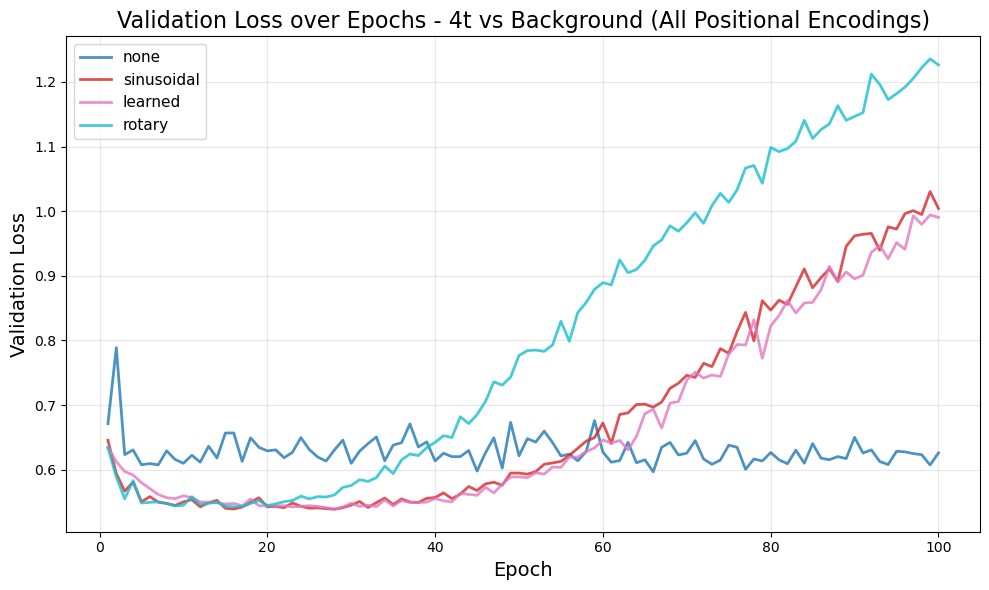

In [7]:
# Plot validation loss over epochs
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.tab10(np.linspace(0, 1, len(run_info)))

for i, info in enumerate(run_info):
    positional = info["positional"]
    val_loss = info.get("history_val_loss", [])
    
    if not val_loss:
        continue
    
    epochs = range(1, len(val_loss) + 1)
    ax.plot(
        epochs,
        val_loss,
        label=f"{positional}",
        color=colors[i],
        linewidth=2,
        alpha=0.8,
    )

ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Validation Loss", fontsize=14)
ax.set_title("Validation Loss over Epochs - 4t vs Background (All Positional Encodings)", fontsize=16)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


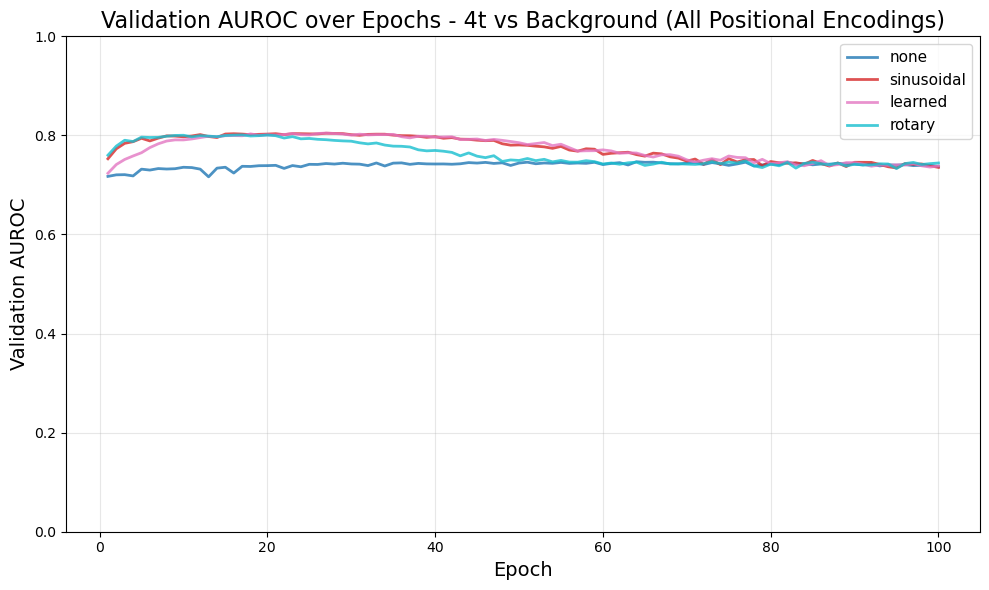

In [8]:
# Plot validation AUROC over epochs
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.tab10(np.linspace(0, 1, len(run_info)))

for i, info in enumerate(run_info):
    positional = info["positional"]
    val_auroc = info.get("history_val_auroc", [])
    
    if not val_auroc:
        continue
    
    epochs = range(1, len(val_auroc) + 1)
    ax.plot(
        epochs,
        val_auroc,
        label=f"{positional}",
        color=colors[i],
        linewidth=2,
        alpha=0.8,
    )

ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Validation AUROC", fontsize=14)
ax.set_title("Validation AUROC over Epochs - 4t vs Background (All Positional Encodings)", fontsize=16)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()


## Plot 1: All 4 ROC Curves


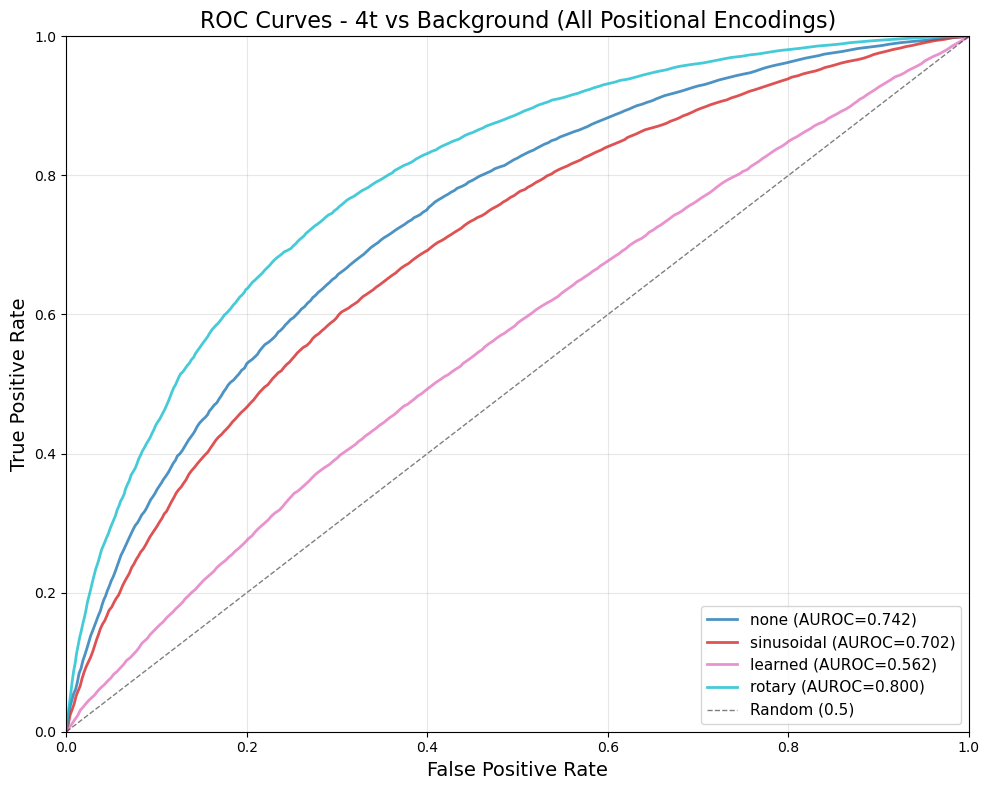

In [9]:
# Create a single plot with all 4 ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

# Create mapping from run_id to info
run_id_to_info = {info["run_id"]: info for info in run_info}

# Sort runs by positional encoding order
positional_order = {"none": 0, "sinusoidal": 1, "learned": 2, "rotary": 3}
sorted_run_ids = sorted(
    inference_results.keys(),
    key=lambda rid: positional_order.get(run_id_to_info.get(rid, {}).get("positional", ""), 999)
)

colors = plt.cm.tab10(np.linspace(0, 1, len(sorted_run_ids)))

for i, run_id in enumerate(sorted_run_ids):
    metrics = inference_results[run_id]
    roc_curves_data = metrics.get("roc_curves", {})
    
    if not roc_curves_data:
        continue
    
    # Get positional encoding info
    info = run_id_to_info.get(run_id, {})
    positional = info.get("positional", run_id)
    
    # For binary classification, plot single curve
    if len(roc_curves_data) == 1:
        class_idx = list(roc_curves_data.keys())[0]
        curve = roc_curves_data[class_idx]
        auroc = metrics.get("auroc", 0.0)
        ax.plot(
            curve["fpr"],
            curve["tpr"],
            label=f"{positional} (AUROC={auroc:.3f})",
            color=colors[i],
            linewidth=2,
            alpha=0.8,
        )

# Diagonal reference line (random classifier)
ax.plot([0, 1], [0, 1], "k--", linewidth=1, alpha=0.5, label="Random (0.5)")

ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.set_title("ROC Curves - 4t vs Background (All Positional Encodings)", fontsize=16)
ax.legend(fontsize=11, loc="lower right")
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()


## Plot 2: Score Distributions for Each Positional Encoding


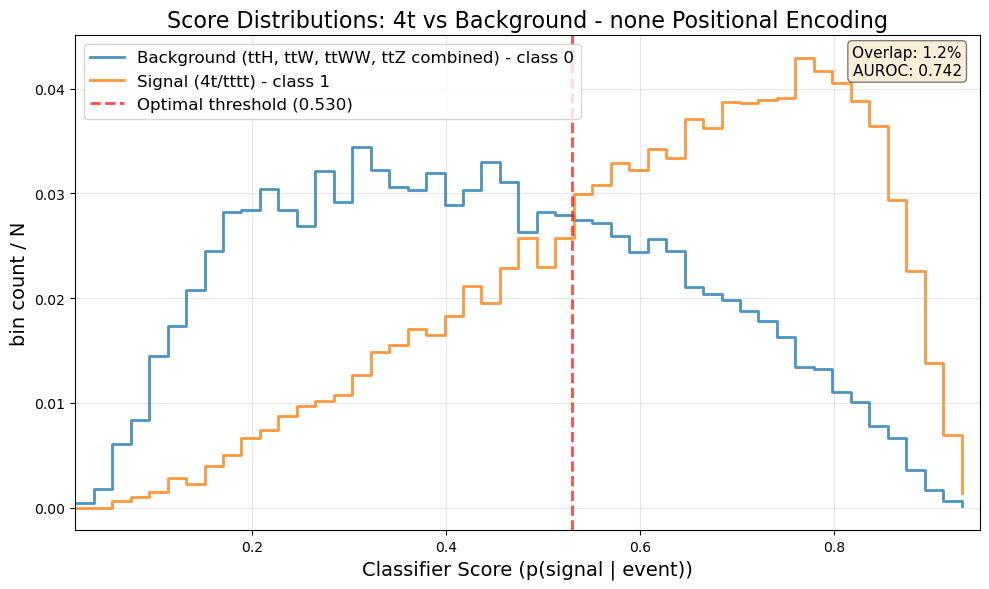

Created plot for none


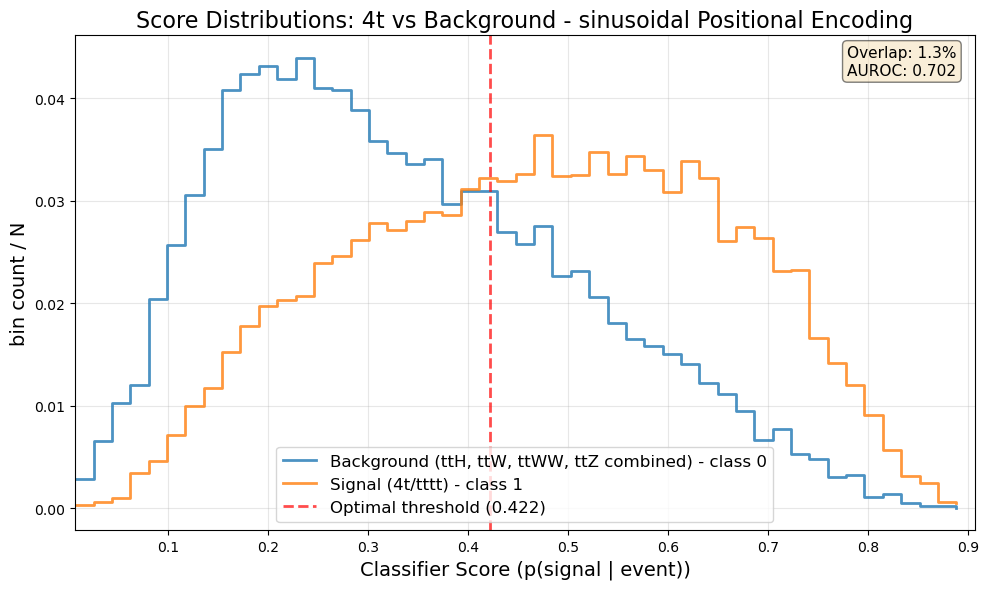

Created plot for sinusoidal


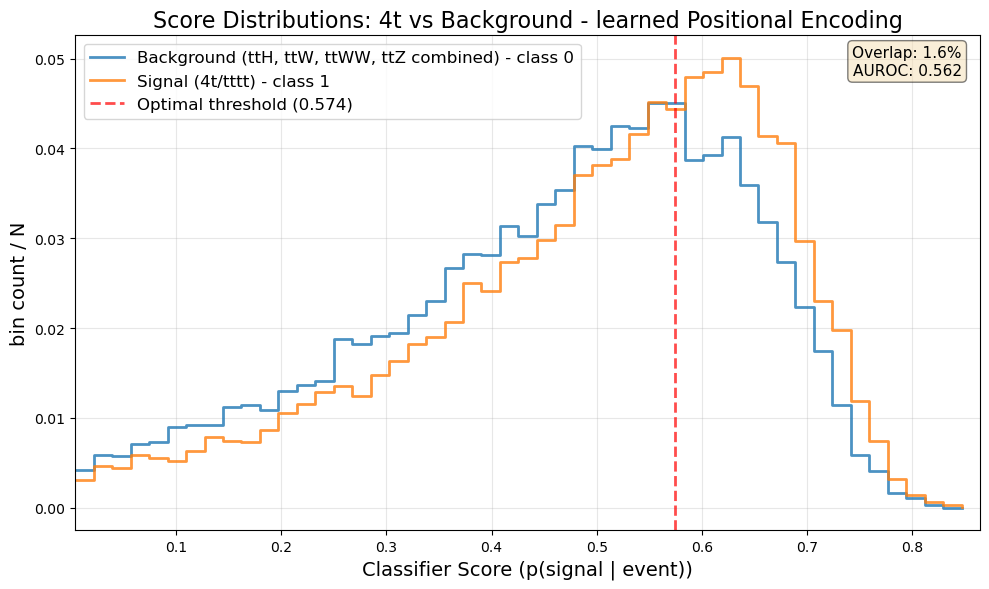

Created plot for learned


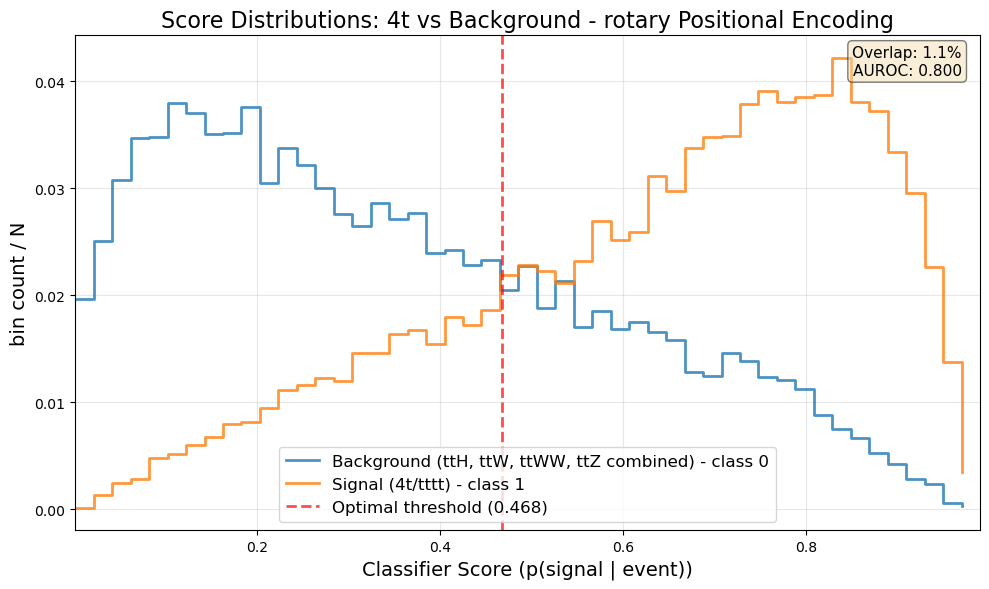

Created plot for rotary

All score distribution plots created!


In [10]:
# Create score distribution plots for each positional encoding
from sklearn.metrics import roc_curve

# Create plots for each run
for info in run_info:
    run_id = info["run_id"]
    positional = info["positional"]
    
    if run_id not in inference_results:
        continue
    
    metrics = inference_results[run_id]
    
    # Extract per-event scores and labels
    per_event_scores = metrics.get("per_event_scores")
    per_event_labels = metrics.get("per_event_labels")
    
    if per_event_scores is None or per_event_labels is None:
        print(f"Skipping {run_id}: missing per_event data")
        continue
    
    scores = np.array(per_event_scores)  # [N] - p(signal | event)
    labels = np.array(per_event_labels)  # [N] - true labels
    
    # Split into signal and background
    # In signal_vs_background mode: signal (label 1) → class 1, background → class 0
    signal_class_idx = 1  # Signal (4t)
    background_class_idx = 0  # Background (ttH, ttW, ttWW, ttZ combined)
    signal_scores = scores[labels == signal_class_idx]
    background_scores = scores[labels == background_class_idx]
    
    if len(signal_scores) == 0 or len(background_scores) == 0:
        print(f"Skipping {run_id}: missing one class")
        continue
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Compute optimal threshold using Youden's J
    y_binary = (labels == signal_class_idx).astype(int)
    fpr, tpr, thresholds = roc_curve(y_binary, scores)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]
    
    # Compute overlap area
    score_min = min(scores.min(), background_scores.min(), signal_scores.min())
    score_max = max(scores.max(), background_scores.max(), signal_scores.max())
    bins = np.linspace(score_min, score_max, 50)
    
    # Compute normalized histograms
    bg_counts, bg_edges = np.histogram(background_scores, bins=bins)
    sig_counts, sig_edges = np.histogram(signal_scores, bins=bins)
    
    # Normalize by total count
    bg_normalized = bg_counts / len(background_scores)
    sig_normalized = sig_counts / len(signal_scores)
    
    # Compute overlap
    overlap = np.minimum(bg_normalized, sig_normalized)
    overlap_area = np.sum(overlap) * (bins[1] - bins[0])
    
    # Plot normalized step histograms
    ax.step(
        bg_edges[:-1],
        bg_normalized,
        where="post",
        label="Background (ttH, ttW, ttWW, ttZ combined) - class 0",
        color="#1f77b4",  # Blue
        linewidth=2,
        alpha=0.8,
    )
    ax.step(
        sig_edges[:-1],
        sig_normalized,
        where="post",
        label="Signal (4t/tttt) - class 1",
        color="#ff7f0e",  # Orange
        linewidth=2,
        alpha=0.8,
    )
    
    # Plot optimal threshold line
    ax.axvline(
        optimal_threshold,
        color="red",
        linestyle="--",
        linewidth=2,
        alpha=0.7,
        label=f"Optimal threshold ({optimal_threshold:.3f})",
    )
    
    # Annotate overlap area
    overlap_pct = overlap_area * 100
    auroc = metrics.get("auroc", 0.0)
    ax.text(
        0.98,
        0.98,
        f"Overlap: {overlap_pct:.1f}%\nAUROC: {auroc:.3f}",
        transform=ax.transAxes,
        ha="right",
        va="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
        fontsize=11,
    )
    
    # Set labels and title
    ax.set_xlabel("Classifier Score (p(signal | event))", fontsize=14)
    ax.set_ylabel("bin count / N", fontsize=14)
    ax.set_title(f"Score Distributions: 4t vs Background - {positional} Positional Encoding", fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)
    ax.set_xlim([score_min, score_max])
    
    plt.tight_layout()
    plt.show()
    
    print(f"Created plot for {positional}")

print("\nAll score distribution plots created!")
